Лаборатрна робота 12


1. Завантаження та підготовка даних

In [134]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/netflix-imdb-scores")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Lenovo Legion 5\.cache\kagglehub\datasets\thedevastator\netflix-imdb-scores\versions\2


In [135]:
import pandas as pd

# Завантажуємо датасет
file_path = r'C:\Users\Lenovo Legion 5\.cache\kagglehub\datasets\thedevastator\netflix-imdb-scores\versions\2\Netflix TV Shows and Movies.csv'
df = pd.read_csv(file_path)

# Переглянемо структуру даних
df.head()


,index,id,title,type,description,release_year,age_certification,runtime,imdb_id,imdb_score,imdb_votes
0,0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,tt0075314,8.3,795222.0
1,1,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,tt0071853,8.2,530877.0
2,2,tm70993,Life of Brian,MOVIE,"Brian Cohen is an average young Jewish man, bu...",1979,R,94,tt0079470,8.0,392419.0
3,3,tm190788,The Exorcist,MOVIE,12-year-old Regan MacNeil begins to adapt an e...,1973,R,133,tt0070047,8.1,391942.0
4,4,ts22164,Monty Python's Flying Circus,SHOW,A British sketch comedy series with the shows ...,1969,TV-14,30,tt0063929,8.8,72895.0


2. Попередня обробка тексту

а) Токенізація, очищення та приведення тексту до нижнього регістру

In [136]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Завантажуємо стоп-слова
nltk.download('punkt')
nltk.download('stopwords')

# Очищаємо текст
def clean_text(text):
    # Перевіряємо, чи є значення текстом
    if isinstance(text, str):
        # Перетворюємо текст на нижній регістр
        text = text.lower()
        
        # Видаляємо пунктуацію
        text = ''.join([char for char in text if char not in string.punctuation])
        
        # Токенізація
        tokens = word_tokenize(text)
        
        # Видаляємо стоп-слова
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
        
        return ' '.join(tokens)
    else:
        # Якщо значення не рядок, повертаємо порожній рядок
        return ''


# Застосуємо функцію до описів
df['cleaned_description'] = df['description'].apply(clean_text)



[nltk_data] Downloading package punkt to C:\Users\Lenovo Legion
[nltk_data]     5\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Lenovo Legion
[nltk_data]     5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


б) Лемматизація

In [137]:
from nltk.stem import WordNetLemmatizer

# Завантажуємо необхідні ресурси для лемматизації
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = text.split()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_text)

# Застосуємо лемматизацію
df['lemmatized_description'] = df['cleaned_description'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to C:\Users\Lenovo Legion
[nltk_data]     5\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


3. Векторизація тексту

In [138]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Використовуємо TF-IDF для векторизації
vectorizer = TfidfVectorizer(max_features=5000)

# Трансформуємо опис в числові вектори
X = vectorizer.fit_transform(df['lemmatized_description'])

# Перевіримо розмір векторів
print(X.shape)


(5283, 5000)


4. Класифікація тексту

In [139]:
# Створення мітки на основі imdb_score
df['label'] = df['imdb_score'].apply(lambda x: 1 if x >= 6.6 else 0)

# Розбиваємо на тренувальний та тестовий набори
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)


Навчання наївного баєсового класифікатора

In [140]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# Ініціалізуємо класифікатор
nb_classifier = MultinomialNB()

# Навчаємо модель
nb_classifier.fit(X_train, y_train)

# Прогнозуємо на тестовому наборі
y_pred = nb_classifier.predict(X_test)

# Оцінка точності
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Матриця похибок
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


Accuracy: 61.12%
Confusion Matrix:
[[264 241]
 [170 382]]


5. Оцінка та аналіз моделі


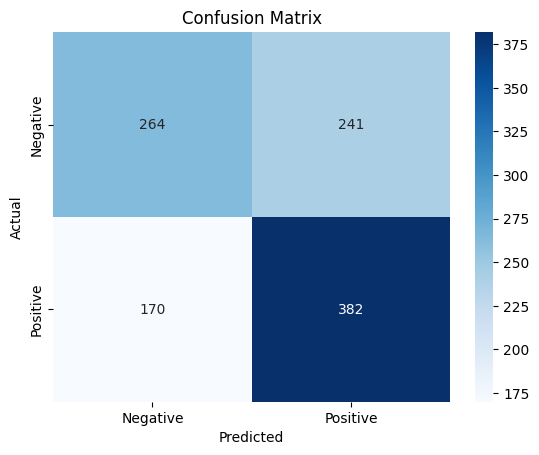

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# Візуалізуємо матрицю похибок
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




In [142]:
# Виводимо кілька прикладів передбачень
num_examples = 10
predictions = y_pred[:num_examples]
true_labels = y_test[:num_examples]

# Виводимо текст, реальні мітки та передбачення
for i in range(num_examples):
    print(f"Example {i+1}:")
    print(f"Description: {df['description'].iloc[i]}")
    print(f"Actual label: {'Positive' if true_labels.iloc[i] == 1 else 'Negative'}")
    print(f"Predicted label: {'Positive' if predictions[i] == 1 else 'Negative'}")
    print("-" * 80)


Example 1:
Description: A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action, attempting to save a preadolescent prostitute in the process.
Actual label: Negative
Predicted label: Negative
--------------------------------------------------------------------------------
Example 2:
Description: King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir Galahad the Pure. On the way, Arthur battles the Black Knight who, despite having had all his limbs chopped off, insists he can still fight. They reach Camelot, but Arthur decides not  to enter, as "it is a silly place".
Actual label: Positive
Predicted label: Positive
--------------------------------------------------------------------------------
Example 3:
Description: Brian Cohen is an averag